<font color=red>DESCRIPTION:</font> Create a model using multivariable Linear Regression to predict house sale price in Ames, Iowa.

This model was created using data from Ames, Iowa home sales between 2006 - 2010. The model was created and validated using the following process:

- shuffle the home sales dataset
- EDA of sales price
- Build functions that
    - clean dataset, removing 1)columns not beneficial for modeling and 2) columns with high %NaN
    - clean dataset, filling remaining NaN columns with column mean or zero
    - create dummy columns for remaing categorical object columns
    - select feature columns based on correlation with target column
    - create test and train datasets
    - build the model
- Create lists of Mean Absolute Error (MAE), Root Mean Square Error(RMSE) from the model for a range of # of features
- Plot MAE, RMSE as a function of # of features
- Plot MAE, RMSE as a function of # of features with the train and test datasets switched (cross validation).

Detailed Conclusions are provided at the end of this Notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\drrdm\Data Quest Guided Projects\14th Guided Project - House Sales\AmesHousing.txt", 
                 delimiter = '\t')

In [55]:
#shuffle the df for randomization

df = df.loc[np.random.permutation(len(df))]

In [3]:
pd.set_option('display.max_columns', None)

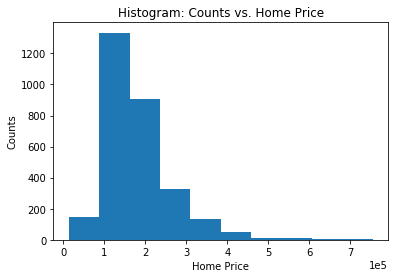

In [12]:
plt.hist(df['SalePrice'])
plt.xlabel("Home Price")
plt.ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
plt.ylabel("Counts")
plt.title("Histogram: Counts vs. Home Price")
plt.show()

In [66]:
#summary statistics
print("Home SalePrice average: ${0:5.0f}".format(df["SalePrice"].mean()))
print("Home SalePrice std dev: ${0:5.0f}".format(df["SalePrice"].std()))

Home SalePrice average: $180796
Home SalePrice std dev: $79887


There are outliers in the `SalePrice`. Evaluate impact outliers have on the`SalePrice` summary statistics.
<br><br><br>

In [67]:
#create df w/o outliers in SalePrice

df_lt5E5 = df[df["SalePrice"] <5e05]

In [69]:
#summary statistics
print("Home SalePrice < 5E05 average: ${0:5.0f}".format(df_lt5E5["SalePrice"].mean()))
print("Home SalePrice < 5E05 std dev: ${0:5.0f}".format(df_lt5E5["SalePrice"].std()))

Home SalePrice < 5E05 average: $178306
Home SalePrice < 5E05 std dev: $73359


There is an approx (80 - 73)/80 = 9% reduction in the std deviation, 2% reduction in the average.
<br><br><br>
Build the model-

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [27]:
#function for feature engineering of columns with string values
def feature_eng(df):
    p_cat_cols = df.select_dtypes(include = 'object').columns
    for col in p_cat_cols:
        my_cols = pd.get_dummies(df[col])
        df = pd.concat([df, my_cols], axis =1)
        del df[col]
    return df

In [28]:
#data cleaning function which deletes > 5% NaN columns, fills remaining float cols NaN with column mean
def transform_features(df):
    df_na = df.copy() #make a copy of the original df
    
    #drop columns with > 5% NaN entries
    thresh = int(len(df) - .05*len(df))
    df_na = df_na.dropna(axis = 1, thresh = thresh)
    df_na["BuiltYr - RemodelYr"] = df['Year Remod/Add'] - df['Year Built']
    
    #drop columns that are not useful for the model
    df_na.drop(columns = ["Mo Sold", "Yr Sold", 'Year Remod/Add', 
                          'Year Built', 'PID', 'Order'], inplace = True)
    
    #fill remaining float columns NaN with mean
    float_cols = df_na.select_dtypes(include = ['float']).columns
    for col in float_cols:
        df_na[col].fillna(value = df_na[col].mean(), inplace = True)
    int_cols = df_na.select_dtypes(include = ['integer']).columns
    for col in int_cols:
        df_na[col].fillna(value = df_na[col].mean(), inplace = True)                               
       
    df_na = df_na.dropna(axis = 1, thresh = int(len(df) - 20))   #drop rows with more than 20 NaN's
    df_na.fillna(value = 0, inplace = True) #fill remaining NaN's with zero 
    df_na = feature_eng(df_na) #call feature engineering function
    return df_na

In [29]:
#function to build df with columns to use as model features based on highest correlation with target
def select_features(df,no_features):
    df_na = transform_features(df)  #call function that drops df columns, fills NaN with mean or zero, 
    
    #sort columns based on correlation w/target
    df_na_corr= df_na.corr()
    df_na_abs = df_na_corr['SalePrice'].abs()
    df_na_corrsort = df_na_abs.sort_values(ascending = False)
    
    #select features based on no. of features input and strength of correlation
    df_model_cols_prep = df_na_corrsort.index.to_list()
    df_model_cols = df_model_cols_prep[0:no_features + 1]
    df_model = df_na[df_model_cols]
    
    return df_model, df_model_cols, no_features

In [70]:
#function to create train and test df's and perform regression
def train_and_test(df,no_features):
    ttdf,ttdf_cols, factors = select_features(df, no_features) #call function to select features
    
    #set train and test df's
    train = ttdf[ttdf_cols].iloc[:1460, :]
    test = ttdf[ttdf_cols].iloc[1460:,:]
    
    #identify model columns, make list of model columns for function return (used in subsequent for loops)
    model_cols = ttdf.drop(columns = 'SalePrice').columns
    model_cols_f = list(model_cols)
    
    #build lr model
    lr = LinearRegression()
    lr.fit(train[model_cols], train["SalePrice"])
    test_predictions = lr.predict(test[model_cols])
    RMSE = mean_squared_error(test['SalePrice'], test_predictions)**.5
    MAE = mean_absolute_error(test['SalePrice'], test_predictions)
    
    return MAE,RMSE,model_cols_f

In [77]:
#check model
train_and_test(df, 9)

(22297.305729824886,
 33722.43985551846,
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Garage Area',
  'Total Bsmt SF',
  '1st Flr SF',
  'TA',
  'TA',
  'TA',
  'TA',
  'Full Bath',
  'Ex',
  'Ex',
  'Ex',
  'Ex'])

<br><br><br>
Get results from the model using 1-20 features and plot-

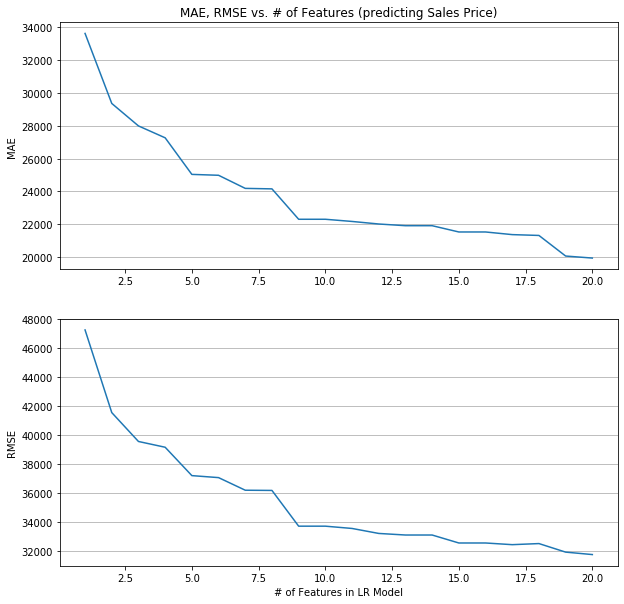

In [79]:
#Get the results from the model for all homes 
factors = []
x = []
yMAE = []
yRMSE = []

for i in range(1,21):
    MAE, RMSE, factors_list = train_and_test(df, i)
    yMAE.append(MAE)
    yRMSE.append(RMSE)
    factors.append(factors_list)
    x.append(i)
    
#Plot model results for all homes
fig = plt.figure(figsize =(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.grid(which = 'major', axis = 'y')
ax2.grid(which = 'major', axis = 'y')
ax1.plot(x,yMAE)
ax2.plot(x,yRMSE)
plt.xlabel("# of Features in LR Model")
ax1.set_ylabel("MAE")
ax2.set_ylabel("RMSE")
ax1.set_title("MAE, RMSE vs. # of Features (predicting Sales Price)")
plt.show()

<br><br><br>
Cross validate model-

In [76]:
#modify train_and_test function to cross validate model, switching the test and train datasets 
def train_and_test_cross(df,no_features):
    ttdf,ttdf_cols, factors = select_features(df, no_features) #call function to select features
    test = ttdf[ttdf_cols].iloc[:1460, :]
    train = ttdf[ttdf_cols].iloc[1460:,:]
    model_cols = ttdf.drop(columns = 'SalePrice').columns
    model_cols_f = list(model_cols)
    lr = LinearRegression()
    lr.fit(train[model_cols], train["SalePrice"])
    test_predictions = lr.predict(test[model_cols])
    RMSE = mean_squared_error(test['SalePrice'], test_predictions)**.5
    MAE = mean_absolute_error(test['SalePrice'], test_predictions)
    target = ttdf_cols[0]
    return MAE,RMSE,model_cols_f

In [74]:
#check model with new function
train_and_test_cross(df, 9)

(34246.16456759339, 49036.99735669356, ['Overall Qual'])

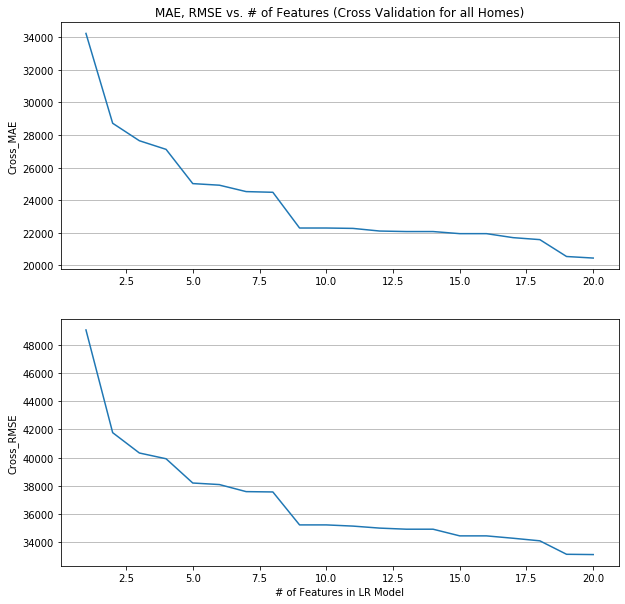

In [80]:
#Get the cross validation results from the model 
 
cross_factors = []
cross_x = []
cross_MAE = []
cross_RMSE = []

for i in range(1,21):
    MAE,RMSE,factors_list = train_and_test_cross(df, i)
    cross_MAE.append(MAE)
    cross_RMSE.append(RMSE)
    cross_factors.append(factors_list)
    cross_x.append(i)

#Plot model results for all homes cross validation
fig = plt.figure(figsize =(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.grid(which = 'major', axis = 'y')
ax2.grid(which = 'major', axis = 'y')
ax1.plot(cross_x,cross_MAE)
ax2.plot(cross_x,cross_RMSE)
plt.xlabel("# of Features in LR Model")
ax1.set_ylabel("Cross_MAE")
ax2.set_ylabel("Cross_RMSE")
ax1.set_title("MAE, RMSE vs. # of Features (Cross Validation for all Homes)")

plt.show()

<font color=red>CONCLUSIONS:</font>

- As the number of factors is increased, RMSE and MSE decrease
- The most significant reduction in RMSE and MSE is between a 1 factor and 9 factor model
- There is not a significant reduction in RMSE and MSE between a 9 and 20 factor model
- Cross validation showed no significant difference in RMSE and MSE
- The 9 factor MSE is ~22,000 USD.
- The standard deviation of SalePrice is ~80,000 USD.  The 9 factor RMSE is ~34,000 USD.  
    -The 9 factor model reduces uncertainty in SalePrice prediction by (80 - 34)/80 = 58%

<br><br><br>
Before ending the analysis, check to see if removing outliers had a significant effect on the MSE, RMSE

In [78]:
train_and_test(df_lt5E5, 9)

(23242.688872574072,
 33656.429817142,
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Garage Area',
  'Total Bsmt SF',
  'TA',
  'TA',
  'TA',
  'TA',
  '1st Flr SF',
  'Full Bath',
  'TA',
  'TA',
  'TA',
  'TA'])

No significant change in MSE (~23,000 USD vs ~22,000 USD) or RMSE (34,000 USD for both) with outlier removed from df.
<br>